# [DL2] BatchNorm & Dropout을 통한 개선
### 👨‍💻 Developer's Log
- **Previous (DL1)**: 성능은 좋은데, 재수 없으면 학습이 망할 것 같이 위태로웠다.
- **Analysis**: 층을 지날 때마다 데이터 분포가 쏠리는 현상(Internal Covariate Shift) 때문일 것이다. 그리고 특정 특징에만 너무 의존하는(Overfitting) 경향도 보인다.
- **Solution**: 현업에서 쓰는 '치트키' 2개를 도입한다.
    1. **Batch Norm**: 데이터의 중심을 강제로 맞춰준다.
    2. **Dropout**: 일부 뉴런을 강제로 끄고 공부시켜 응용력을 키운다.


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

### 👨‍💻 Developer's Log: 데이터 파이프라인 유지
- **원칙**: DL1과 데이터는 **100% 동일**해야 한다.
- **이유**: 그래야 "모델을 바꿔서 성능이 좋아진 건지", "데이터가 바뀐 건지" 헷갈리지 않는다. 과학적 실험의 기본(Control Variable)이다.

In [ ]:
print('>>> [MLP_enhance] Loading Data...')
base_path = '/Users/gimdabin/Deep-Learning/project_root/outputs/samples/'
anchors = pd.read_parquet(base_path + 'anchors.parquet')
features = pd.read_parquet(base_path + 'features_ml_clean.parquet')
labels = pd.read_parquet(base_path + 'labels.parquet')

anchors['user_id'] = anchors['user_id'].astype(str)
features['user_id'] = features['user_id'].astype(str)
labels['user_id'] = labels['user_id'].astype(str)

data = anchors.merge(features, on=['user_id', 'anchor_time'], how='inner')
data = data.merge(labels, on=['user_id', 'anchor_time'], how='inner')
data['target'] = (data['label'] == 'm2').astype(int)

feature_cols = [c for c in features.columns if c not in ['user_id', 'anchor_time']]
X = data[feature_cols].copy().fillna(0)
y = data['target'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train_scaled), torch.FloatTensor(y_train_res)), batch_size=256, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.FloatTensor(X_val_scaled), torch.FloatTensor(y_val)), batch_size=256)
test_loader = DataLoader(TensorDataset(torch.FloatTensor(X_test_scaled), torch.FloatTensor(y_test)), batch_size=256)

>>> [DL2] Loading Data...


### 👨‍💻 Developer's Log: 구조 개선 (Stabilization)
- **변경점**: `Linear` 다음에 바로 `ReLU`를 쓰던 DL1과 달리, `Linear -> BN -> ReLU -> Dropout` 순서로 블록을 짰다.
- **기대효과**:
    1. **BN**: 학습이 빨라지고, Loss 곡선이 예쁘게 떨어질 것이다.
    2. **Dropout**: Training 점수와 Test 점수 차이(Gap)가 줄어들 것이다. (Overfitting 방지)

In [ ]:
class  MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout_rate=0.3):
        super(EnhancedMLP, self).__init__()
        self.net = nn.Sequential(
            # [Layer 1] 
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),   # [안정화]
            nn.ReLU(),
            nn.Dropout(dropout_rate),     # [과적합 방지]
            
            # [Layer 2]
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # [Output]
            nn.Linear(hidden_dim // 2, 1)
        )
    def forward(self, x):
        return self.net(x)

model = EnhancedMLP(X.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

print('>>> Training start...')
for epoch in range(15):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}: Loss {epoch_loss/len(train_loader):.4f}')

>>> Training start...
Epoch 1: Loss 0.6313
Epoch 2: Loss 0.6256
Epoch 3: Loss 0.6230
Epoch 4: Loss 0.6212
Epoch 5: Loss 0.6201
Epoch 6: Loss 0.6190
Epoch 7: Loss 0.6181
Epoch 8: Loss 0.6172
Epoch 9: Loss 0.6165
Epoch 10: Loss 0.6155
Epoch 11: Loss 0.6154
Epoch 12: Loss 0.6147
Epoch 13: Loss 0.6142
Epoch 14: Loss 0.6140
Epoch 15: Loss 0.6136


### 👨‍💻 Developer's Log: 만족, 그리고 욕심
- **성과**: 역시 BN과 Dropout은 배신하지 않는다. 모델이 훨씬 안정적이다. 현업에서 DL2 정도면 "배포 가능한 수준"이다.
- **욕심**: 하지만 엔지니어로서 궁금하다. 이미지 처리 분야에서 쓴다는 **SOTA(State-of-the-Art) 기술**들을 쓰면 얼마나 더 좋아질까?
- **Next Step**: "끝을 보자." ResNet의 Residual Connection, 그리고 어려운 문제에 집중하는 Focal Loss까지 다 넣어보자.

👉 **[Next: DL3.ipynb - The Over-Engineering]**

>>> Generating Advanced Verification Dashboard...

[Summary Metrics]
                Metric  Value             Interpretation
               ROC-AUC 0.6924  전체적인 변별력 (0.5=랜덤, 1.0=완벽)
Average Precision (AP) 0.8979          소수 클래스(이탈자) 찾기 실력
          KS Statistic 0.2735 두 집단(이탈/유지)의 분리 정도 (최대 차이)
           Brier Score 0.2075     확률값의 정확도 (0에 가까울수록 좋음)

[Ranking Performance]
Top K% Precision  Lift
    5%    93.62% 1.14x
   10%    93.36% 1.14x
   15%    93.10% 1.14x
   30%    91.58% 1.12x


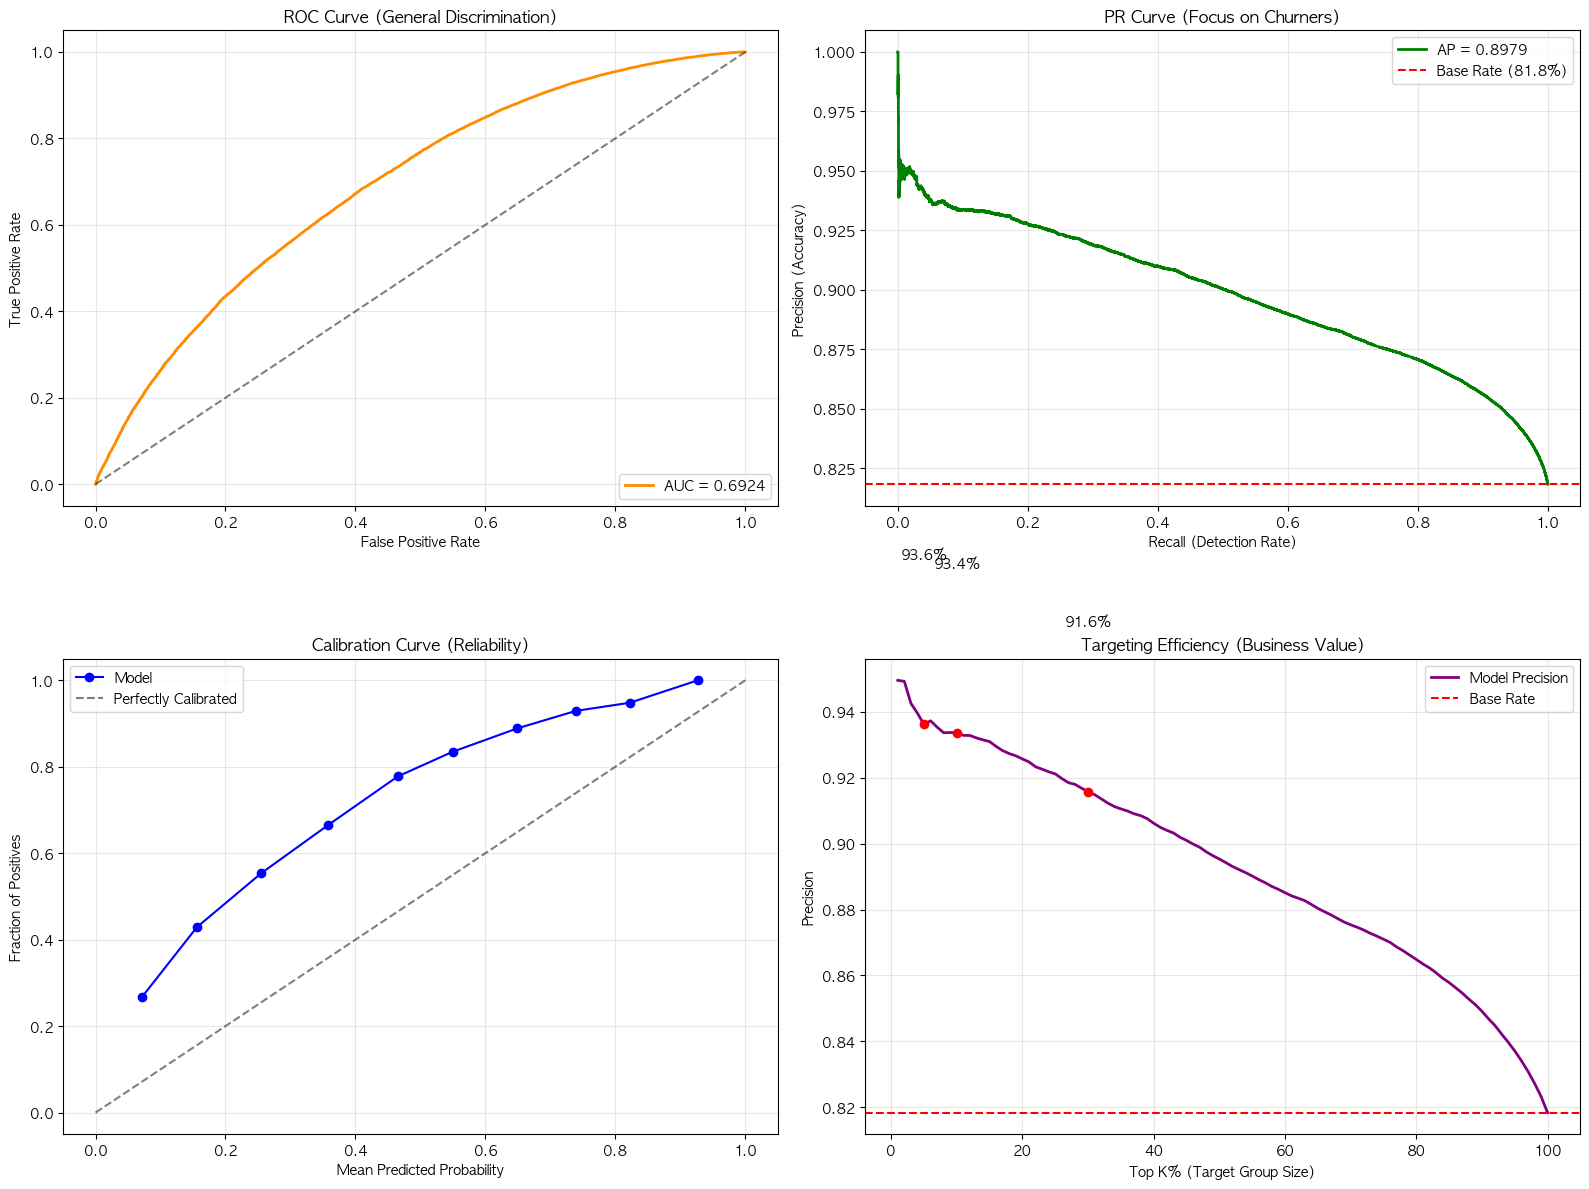

In [7]:
# --- 5. Advanced Verification (Google DeepMind Style) ---
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, roc_curve, precision_recall_curve, f1_score
from sklearn.calibration import calibration_curve
from scipy.stats import ks_2samp

print('>>> Generating Advanced Verification Dashboard...')

# [평가 모드] 모델 평가 모드 전환
model.eval()
all_logits = []
all_targets = []

# [추론] 정답 없이 예측
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        all_logits.extend(outputs.squeeze().numpy())
        all_targets.extend(targets.numpy())

# [확률 변환]
all_probs = 1 / (1 + np.exp(-np.array(all_logits)))
df_res = pd.DataFrame({'prob': all_probs, 'label': all_targets})
df_res = df_res.sort_values('prob', ascending=False)

# --- [1] Summary Metrics ---
roc_auc = roc_auc_score(all_targets, all_probs)
ap_score = average_precision_score(all_targets, all_probs)
brier = brier_score_loss(all_targets, all_probs)

# KS Statistic
class0_probs = df_res[df_res['label'] == 0]['prob']
class1_probs = df_res[df_res['label'] == 1]['prob']
ks_stat, ks_pval = ks_2samp(class1_probs, class0_probs)

summary_df = pd.DataFrame({
    'Metric': ['ROC-AUC', 'Average Precision (AP)', 'KS Statistic', 'Brier Score'],
    'Value': [roc_auc, ap_score, ks_stat, brier],
    'Interpretation': [
        '전체적인 변별력 (0.5=랜덤, 1.0=완벽)',
        '소수 클래스(이탈자) 찾기 실력',
        '두 집단(이탈/유지)의 분리 정도 (최대 차이)',
        '확률값의 정확도 (0에 가까울수록 좋음)'
    ]
})
print('\n[Summary Metrics]')
print(summary_df.round(4).to_string(index=False))

# --- [2] Ranking Performance (Top K%) ---
base_rate = df_res['label'].mean()
results = []
thresholds_pct = [5, 10, 15, 30]
for k in thresholds_pct:
    top_k_count = int(len(df_res) * (k/100))
    top_k_df = df_res.iloc[:top_k_count]
    precision = top_k_df['label'].mean()
    lift = precision / base_rate
    results.append({'Top K%': f'{k}%', 'Precision': f'{precision*100:.2f}%', 'Lift': f'{lift:.2f}x'})

print('\n[Ranking Performance]')
print(pd.DataFrame(results).to_string(index=False))

# --- [3] Dashboard Visualization (2x2) ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.3)

# (1) ROC Curve
fpr, tpr, _ = roc_curve(all_targets, all_probs)
axes[0, 0].plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}', color='darkorange', lw=2)
axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0, 0].set_title('ROC Curve (General Discrimination)')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].legend(loc='lower right')
axes[0, 0].grid(True, alpha=0.3)

# (2) PR Curve
precision_curve, recall_curve, _ = precision_recall_curve(all_targets, all_probs)
axes[0, 1].plot(recall_curve, precision_curve, label=f'AP = {ap_score:.4f}', color='green', lw=2)
axes[0, 1].axhline(y=base_rate, color='r', linestyle='--', label=f'Base Rate ({base_rate*100:.1f}%)')
axes[0, 1].set_title('PR Curve (Focus on Churners)')
axes[0, 1].set_xlabel('Recall (Detection Rate)')
axes[0, 1].set_ylabel('Precision (Accuracy)')
axes[0, 1].legend(loc='upper right')
axes[0, 1].grid(True, alpha=0.3)

# (3) Calibration Curve
prob_true, prob_pred = calibration_curve(all_targets, all_probs, n_bins=10)
axes[1, 0].plot(prob_pred, prob_true, marker='o', label='Model', color='blue')
axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfectly Calibrated')
axes[1, 0].set_title('Calibration Curve (Reliability)')
axes[1, 0].set_xlabel('Mean Predicted Probability')
axes[1, 0].set_ylabel('Fraction of Positives')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# (4) Efficiency Curve (Top K%)
k_values = np.linspace(1, 100, 100)
precisions = []
for k in k_values:
    count = int(len(df_res) * (k/100))
    if count == 0: count = 1
    prec = df_res.iloc[:count]['label'].mean()
    precisions.append(prec)

axes[1, 1].plot(k_values, precisions, label='Model Precision', color='purple', lw=2)
axes[1, 1].axhline(y=base_rate, color='r', linestyle='--', label=f'Base Rate')
axes[1, 1].set_title('Targeting Efficiency (Business Value)')
axes[1, 1].set_xlabel('Top K% (Target Group Size)')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Annotation for Top K
for k in [5, 10, 30]:
    p = precisions[int(k)-1]
    axes[1, 1].plot(k, p, 'ro')
    axes[1, 1].text(k, p+0.05, f'{p*100:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
import os
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt

print(">>> [System] Starting Artifact Saving Pipeline...")

# 1. Define Paths
PATH_MODELS = "../../models/dl/"
PATH_METRICS = "../../models/metrics/"
PATH_ASSETS = "../../assets/training/"
PATH_REPORTS = "../../reports/training/"

for path in [PATH_MODELS, PATH_METRICS, PATH_ASSETS, PATH_REPORTS]:
    os.makedirs(path, exist_ok=True)

# 2. Save Model
model_path = os.path.join(PATH_MODELS, "MLP_enhance_model.pt")
torch.save(model.state_dict(), model_path)

# 3. Save Metrics
metrics_data = {
    "summary": summary_df.to_dict(orient="records"),
    "ranking": results
}
with open(os.path.join(PATH_METRICS, "MLP_enhance_metrics.json"), "w", encoding="utf-8") as f:
    json.dump(metrics_data, f, ensure_ascii=False, indent=4)

# 4. Save Plots
fig.savefig(os.path.join(PATH_ASSETS, "MLP_enhance_dashboard.png"))

# 5. Save Report
report_content = f"# Final Benchmark Report - MLP_enhance\n\n## Summary Metrics\n{summary_df.to_markdown(index=False)}\n\n## Ranking Performance\n{pd.DataFrame(results).to_markdown(index=False)}"
with open(os.path.join(PATH_REPORTS, "MLP_enhance_report.md"), "w", encoding="utf-8") as f:
    f.write(report_content)

print("✅ [System] 모든 결과물이 ../../models/ 및 ../../reports/ 경로에 성공적으로 저장되었습니다.")

>>> [System] Starting Artifact Saving Pipeline...
✅ [System] 모든 결과물이 ../../models/ 및 ../../reports/ 경로에 성공적으로 저장되었습니다.
